In [1]:
import tensorflow as tf
from sklearn.metrics import mean_squared_error, euclidean_distances, median_absolute_error
import numpy as np
import pandas as pd
from astroNN.nn.layers import MCDropout
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
import scipy.integrate as intg

# Large data set

In [2]:
model = tf.keras.models.load_model('models/large_lsst_model.h5', custom_objects={'MCDropout': MCDropout})

In [40]:
data_folder = 'Data_SNIa_LSST/larger/'
df_data = pd.read_csv(data_folder+'hubble_diagram.txt', skiprows=5, sep=' ')
# Np = len(dfp.values)
# N s=  len(dfs.values)
df_data.head()

,CID,IDSURVEY,zCMB,zHEL,MU,MUERR,MUERR_VPEC,MUERR_SYS
0,SN:2521,50,0.01988,0.01988,34.84680,0.1320,0.0736,0.00796
1,SN:57482,50,0.02321,0.02321,34.89863,0.1551,0.0631,0.00720
2,SN:52921,50,0.02364,0.02364,35.28915,0.1243,0.0620,0.00771
3,SN:21365,50,0.02470,0.02470,35.11988,0.1444,0.0594,0.00717
4,SN:117311,50,0.02471,0.02471,35.19347,0.1232,0.0593,0.00702


In [39]:
df_data['errors'] = df_data['MUERR'].values+df_data['MUERR_SYS'].values
df_data.head()

KeyError: 'MUERR'

In [5]:
df_data = df_data[['zCMB', 'MU', 'errors']]

In [7]:
z_or = df_data[['zCMB']].values
y = df_data[['MU', 'errors']].values
zmin, zmax = np.min(z_or), np.max(z_or)


In [8]:
scalerz = StandardScaler()
scalerz.fit(z_or.reshape(-1,1))
# apply transform
z = scalerz.transform(z_or.reshape(-1,1))

In [29]:
# Generate test data
# test_batch_size = 500
test_batch_size = len(z)
x_test = z

mc_dropout_num = 100 # Run Dropout 100 times
predictions = np.zeros((mc_dropout_num, test_batch_size, 2))
uncertainty = np.zeros((mc_dropout_num, test_batch_size, 1))
for i in range(mc_dropout_num):
    predictions[i] = model.predict(scalerz.transform(z_or.reshape(-1,1)))
#     predictions[i] = model.predict(scalerz.transform(x_test.reshape(-1,1)))
    
# get mean results and its varience
prediction_mc_dropout = np.mean(predictions, axis=0)
std_mc_dropout = np.std(predictions, axis=0)


181/181 [==============================] - 0s 1ms/step


In [30]:
def RHSquared_a_owacdm(a, w0, wa, Om):
    rhow = a**(-3*(1.0+w0+wa))*np.exp(-3*wa*(1-a))
    return (Om/a**3+(1.0-Om)*rhow)

def DistIntegrand_a(a, w0, wa, Om):
        return 1./np.sqrt(RHSquared_a_owacdm(a, w0, wa, Om))/a**2
    
def Da_z(z, w0, wa, Om):
        r = intg.quad(DistIntegrand_a, 1./(1+z), 1, args=(w0, wa, Om))
        r = r[0]
        return r

### Hay que revisar esta constante en el return
def distance_modulus(z, w0=-1, wa=0.0, Om=0.23):
    return 5*np.log10(Da_z(z, w0, wa, Om)*(1+z))+24
# +43

# zmodel = np.linspace(0.01, 2.4, 100)
zmodel = z_or
flcdm = []
# fowacdm1 = []
# fowacdm2 = []
# fowacdm3 = []

om = 0.27
for zzz in zmodel:
    flcdm.append(distance_modulus(zzz, w0=-1, wa=0, Om=om))

In [31]:
len(prediction_mc_dropout[:,0]), len(x_test), len(zmodel)

(5785, 5785, 5785)

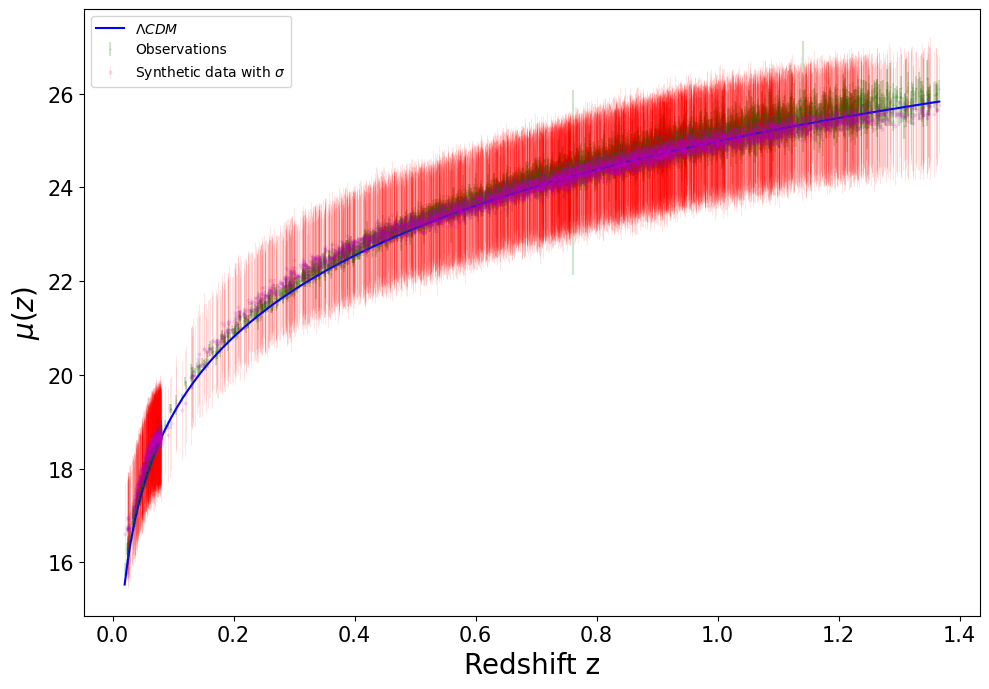

In [32]:
# Plotting
plt.figure(figsize=(10, 7), dpi=100)
# plt.figure(figsize=(5, 4), dpi=100)
sigma = np.sqrt(std_mc_dropout[:, 0]**2 + std_mc_dropout[:, 1]**2+ prediction_mc_dropout[:,1]**2)


# plt.scatter(scalerz.inverse_transform(zz), yy, color='k', label='Original cosmic chronometers')
plt.plot(zmodel, flcdm, label='$\Lambda CDM$', c='b')
plt.errorbar(df_data['zCMB'], df_data['MU']-19, df_data['errors'], fmt='g.', markersize=1, alpha=0.2, label='Observations')
plt.errorbar(z_or, prediction_mc_dropout[:,0]-19, yerr=sigma, markersize=2, fmt='o', 
             ecolor='r', capthick=2, elinewidth=0.8, alpha=0.1, c='m',
             label='Synthetic data with $\sigma$')

# plt.xlim(zmin-0.01,zmax+0.01)

# plt.xlabel('Redshift')
# plt.ylabel('$H(z)$')
plt.ylabel("$\mu(z)$", fontsize=20)
plt.xlabel("Redshift z", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.legend(loc='best')
plt.legend(loc='upper left')
# plt.show()
plt.tight_layout()

In [33]:
flcdm

[array([15.5260231]),
 array([15.86790858]),
 array([15.90849035]),
 array([16.00551106]),
 array([16.00640673]),
 array([16.01712718]),
 array([16.0577563]),
 array([16.05863146]),
 array([16.06823589]),
 array([16.07432658]),
 array([16.11821215]),
 array([16.12331951]),
 array([16.13434596]),
 array([16.13519192]),
 array([16.18785875]),
 array([16.1944596]),
 array([16.23609296]),
 array([16.23932613]),
 array([16.24497309]),
 array([16.30931167]),
 array([16.31478691]),
 array([16.3186897]),
 array([16.35505104]),
 array([16.55264347]),
 array([16.57365151]),
 array([16.62533871]),
 array([16.64973805]),
 array([16.65310627]),
 array([16.67254447]),
 array([16.69049435]),
 array([16.69644639]),
 array([16.75126275]),
 array([16.76155639]),
 array([16.76604531]),
 array([16.78708938]),
 array([16.82298808]),
 array([16.8441361]),
 array([16.85402088]),
 array([16.86631712]),
 array([16.87182896]),
 array([16.88098598]),
 array([16.9339822]),
 array([16.93636225]),
 array([16.966493

In [37]:
# mean_squared_error, euclidean_distances, median_absolute_error
mse_lcdm = mean_squared_error(df_data['MU'].values-19, flcdm)
mse_neural = mean_squared_error(df_data['MU'].values-19, np.sort(prediction_mc_dropout[:,0]-19))
mse_lcdm, mse_neural

(0.03822935108607057, 0.03778299061341408)

In [35]:
np.sort(prediction_mc_dropout[:,0])-19

array([16.60825443, 16.6778812 , 16.69340389, ..., 25.8369165 ,
       25.84802986, 25.87519318])

In [36]:
np.sort(df_data['MU'].values)-19

array([15.8468 , 15.89863, 16.09582, ..., 26.24313, 26.33098, 26.43075])